In [124]:
# Librerias necesarias
import pandas as pd
import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import chisquare, kstest, pearsonr, ks_2samp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import parametros as p

In [3]:
# Cargar los datos
df = pd.read_excel("../data/0 TimeLog (original, no modificar).xlsx")

In [75]:
# Copio para no modificar el original
tl = df.copy()

In [193]:
display(tl["TI"].describe())
display(tl["TF"].describe())
(50496 + 12)/12

count    498258.000000
mean      25173.037366
std       14458.987475
min          12.000000
25%       12636.000000
50%       25164.000000
75%       37692.000000
max       50496.000000
Name: TI, dtype: float64

count    498258.000000
mean      25336.996424
std       14457.291595
min          12.000000
25%       12816.000000
50%       25332.000000
75%       37860.000000
max       50508.000000
Name: TF, dtype: float64

4209.0

In [84]:
# Filtro los que estan en alguna de esas unidades
tl_unidades = tl[tl["UNIDAD"].isin(["ICU", "SDU_WARD", "OR"])]
# Agrupo por ID y UNIDAD, agrego la primera unidad a la que se van
agrupado = tl_unidades.groupby("ID")["UNIDAD"].first().reset_index().rename(columns={"UNIDAD": "REQUERIMIENTO"})
# Merge entre tabla original y el requerimiento a la que se fue cada paciente, si fueron a PS queda NA
merge = tl.merge(agrupado, on="ID", how="left")
# Me quedo con el primer evento de cada paciente que ya contiene su requerimiento
llegadas = merge.groupby("ID").first().reset_index()
display(llegadas.head(5))

,ID,MS_GRD,UBICACIÓN,TI,TF,HOSPITAL,UNIDAD,REQUERIMIENTO
0,1,5,WL_WL,12,384,WL,WL,ICU
1,2,5,WL_WL,12,1224,WL,WL,None
2,3,6,WL_WL,12,12,WL,WL,OR
3,4,7,WL_WL,12,12,WL,WL,OR
4,5,7,WL_WL,12,12,WL,WL,OR


In [149]:
def calculate_kde_metrics(data, ocurrencias, kde):
    # Puntos de intersección entre data y kde (en los enteros: 1, 2, 3 ...)
    x_vals = np.linspace(int(min(data)), int(max(data)), int(max(data)) - int(min(data)) + 1)
    log_dens = kde.score_samples(x_vals[:, None])
    kde_pdf = np.exp(log_dens)

    # Almaceno el data y sus ocurrencias en un diccionario
    dict_temporal = {int(data[i]): ocurrencias[i] for i in range(len(data))}
    # Genero ocurrencias nuevamente pero agregando un cero en los intervalos sin ocurrencias
    ocurrencias_con_cero = np.array([dict_temporal.get(i, 0) for i in range(int(min(data)), int(max(data)) + 1)])

    # Calculo las métricas para el kde (que es el unico que voy a usar)
    def get_metrics(y_true, y_pred):
        prediccion = y_pred * (y_true.sum() / y_pred.sum())  # reescala predicciones para el test
        chi2 = chisquare(f_obs=y_true, f_exp=prediccion)
        ks_stat = ks_2samp(y_true, y_pred, method = "asymp")
        cc = pearsonr(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)

        return {
            'Chi2': {"Value": round(chi2.statistic, 3), "p-value": round(chi2.pvalue, 3)},
            'KS': {"Value": round(ks_stat.statistic, 3), "p-value": round(ks_stat.pvalue, 3)},
            'CC': {"Value": round(cc.statistic, 3), "p-value": round(cc.pvalue, 3)},
            'R2': {"Value": round(r2, 3), "p-value": "NA"},
            'RMSE': {"Value": round(rmse, 3), "p-value": "NA"},
            'MAE': {"Value": round(mae, 3), "p-value": "NA"}
        }
    metrics = get_metrics(ocurrencias_con_cero, kde_pdf * ocurrencias.sum())

    return metrics, kde_pdf

In [209]:
def ajuste_kde(dato: list, ocurrencias: list, bandwidth: float = 1, pvalue: float = 0.06, plot: bool = True, titulo_plot: str = "Ajuste KDE"):
    """
    Ajusta un modelo de Kernel Density Estimation (KDE) a los datos proporcionados y calcula métricas de ajuste.
    
    Args:
        dato (list): Lista de datos a ajustar.
        ocurrencias (list): Lista de ocurrencias correspondientes a los datos.
        bandwidth (float): Ancho de banda para el KDE.
        plot (bool): Si True, se graficará el histograma y el KDE ajustado.
    
    Returns:
        dict: Diccionario con las métricas de ajuste.
    """    
    ###################### Datos a analizar ######################
    dato = np.array(dato) # Aca no se divide por 12 ya que es cantidad de llegadas por dia
    ocurrencias = np.array(ocurrencias)
    raw_data = np.repeat(dato, ocurrencias)
    ##############################################################
    pvalue_obtenido = 0
    while pvalue_obtenido < pvalue:
        # Estimador del kernerl density discreto #####################
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(raw_data[:, None])
        # Calculo el valor p de la prueba de chi2
        metricas, kde_pdf = calculate_kde_metrics(dato, ocurrencias, kde)
        pvalue_obtenido = metricas["Chi2"]["p-value"]
        # Si el pvalue obtenido es menor al pvalue deseado, disminuyo el ancho de banda
        if pvalue_obtenido < pvalue:
            # Disminuyo el ancho de banda
            bandwidth -= 0.005
            # Si el ancho de banda es menor a 0.01, salgo del while
            if bandwidth < 0.01:
                print("No se encontró un ancho de banda adecuado sobre 0.5")
                break
        ##############################################################

    if plot:
        ###################### Plot ##################################
        # Histograma de los datos, tantos bins como el valor maximo de los datos
        plt.figure(figsize=(10, 3)) # tamaño grafico
        plt.bar(dato, ocurrencias / ocurrencias.sum(), alpha=0.6, color='g', edgecolor='black', label='Bar Plot')

        # pdf del KDE ajustado a los datos
        x_vals = np.linspace(min(raw_data), max(raw_data), 1000)
        log_dens = kde.score_samples(x_vals[:, None])
        kde_pdf = np.exp(log_dens)
        plt.plot(x_vals, kde_pdf, color='black', label=f'KDE (Bandwidth = {round(bandwidth,2)})')
        # puntos de las intersecciones
        x_vals_puntos = np.linspace(int(min(raw_data)), int(max(raw_data)), int(max(raw_data)) - int(min(raw_data)) + 1)
        log_dens_puntos = kde.score_samples(x_vals_puntos[:, None])
        kde_pdf_puntos = np.exp(log_dens_puntos)
        plt.scatter(x_vals_puntos, kde_pdf_puntos, color='red', label=f'KDE intersecciones')


        # Leyendas y nombres
        plt.xlabel('LOS')
        plt.ylabel('Densidad')
        plt.title(titulo_plot)
        plt.legend()
        plt.grid(True)
        plt.show()
        ##############################################################
    
    return kde, kde_pdf, metricas, bandwidth

In [207]:
# Para visualizar los datos de llegadas (cambiar requerimiento y grd que se quiera ver)
v1 = llegadas[(llegadas["REQUERIMIENTO"] == "OR") & (llegadas["MS_GRD"] == 5)]
vector = v1["TI"].value_counts().reset_index().sort_values(by="TI")
vector.columns = ["TI", "OCURRENCIAS"]
v2 = vector["OCURRENCIAS"].value_counts().reset_index()
v2.columns = ["VALOR", "OCURRENCIAS"]
v2.sort_values(by="VALOR", inplace=True)

# Agregar la cantidad de veces que no llego nadie, osea valor 0
ciclos_simulacion = int(tl["TI"].max()/12)
# agregar nueva fila
cero_ocurrencias = {"VALOR": 0, "OCURRENCIAS": ciclos_simulacion - v2["OCURRENCIAS"].sum()}
v2 = pd.concat([v2, pd.DataFrame([cero_ocurrencias])], ignore_index=True)
# Ordenar por VALOR
v2.sort_values(by="VALOR", inplace=True)
v2.reset_index(inplace=True)
v2.drop(columns=["index"], inplace=True)

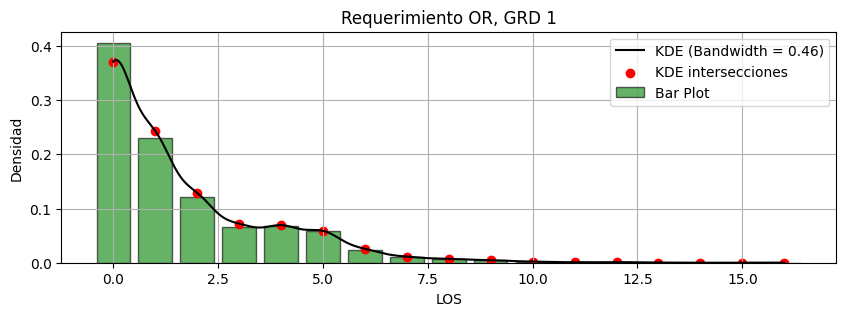

Requerimiento OR, GRD 1, Chi2: 23.51, p-value: 0.101, Bandwidth: 0.46000000000002084


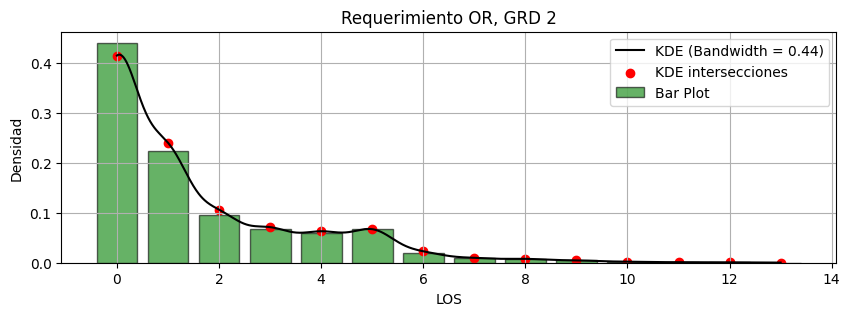

Requerimiento OR, GRD 2, Chi2: 20.423, p-value: 0.085, Bandwidth: 0.4400000000000208


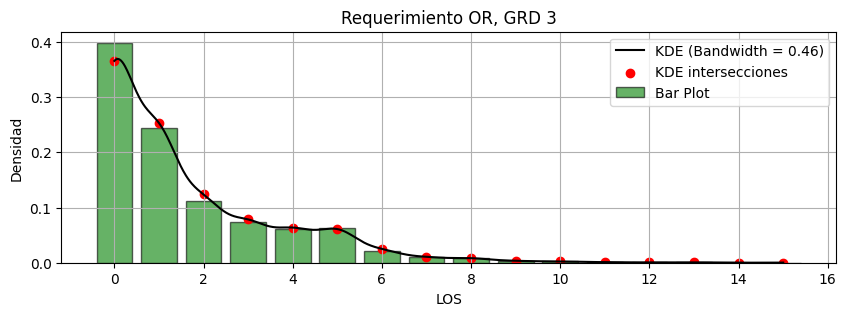

Requerimiento OR, GRD 3, Chi2: 22.646, p-value: 0.092, Bandwidth: 0.46000000000002084


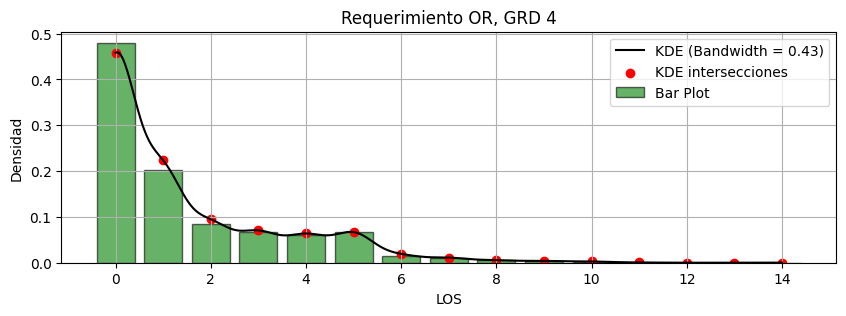

Requerimiento OR, GRD 4, Chi2: 21.475, p-value: 0.09, Bandwidth: 0.4300000000000208


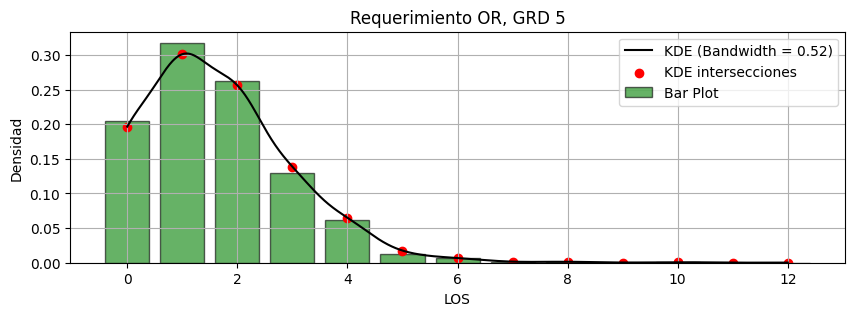

Requerimiento OR, GRD 5, Chi2: 19.638, p-value: 0.074, Bandwidth: 0.5150000000000209


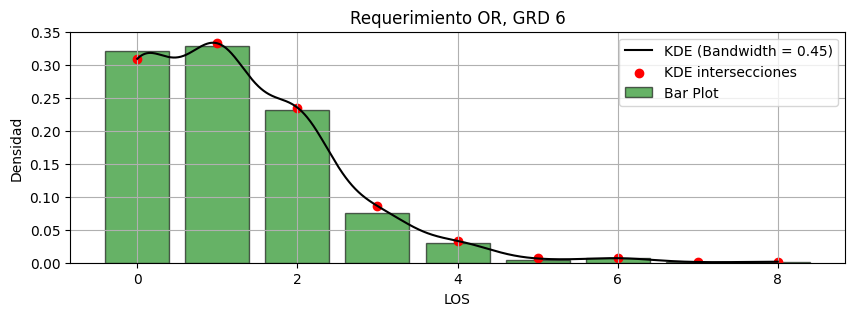

Requerimiento OR, GRD 6, Chi2: 14.263, p-value: 0.075, Bandwidth: 0.45000000000002083


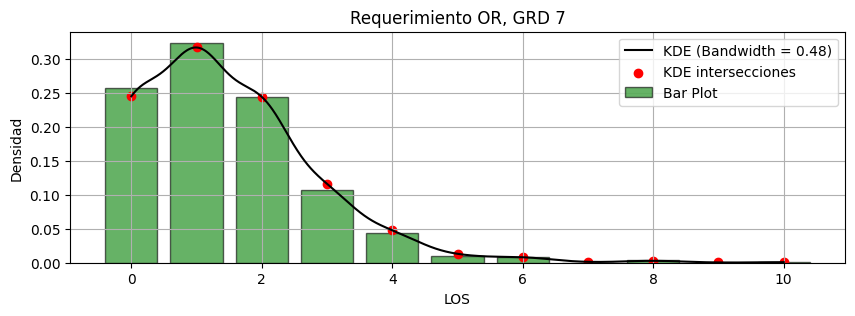

Requerimiento OR, GRD 7, Chi2: 17.54, p-value: 0.063, Bandwidth: 0.48000000000002085


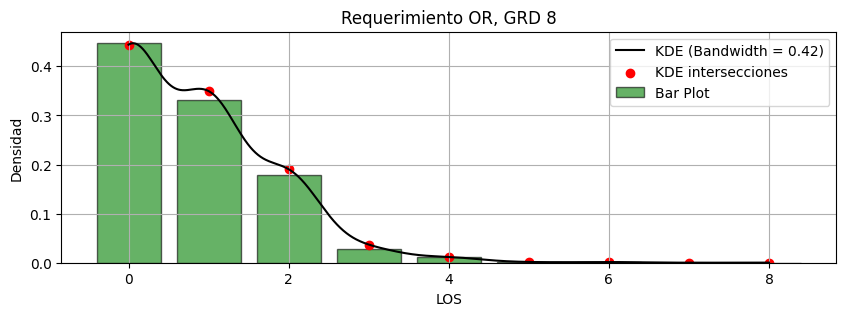

Requerimiento OR, GRD 8, Chi2: 13.524, p-value: 0.095, Bandwidth: 0.4200000000000208


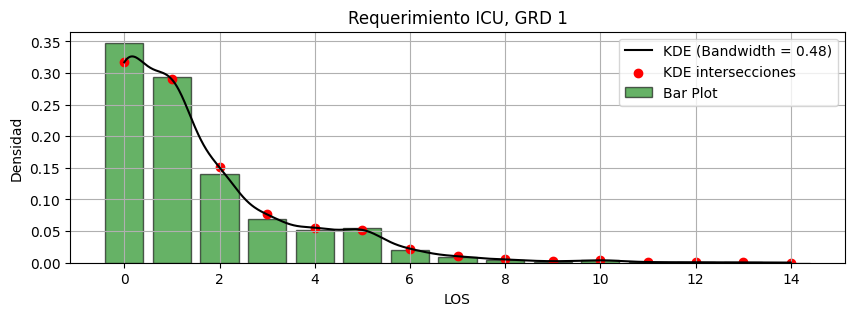

Requerimiento ICU, GRD 1, Chi2: 21.734, p-value: 0.084, Bandwidth: 0.48000000000002085


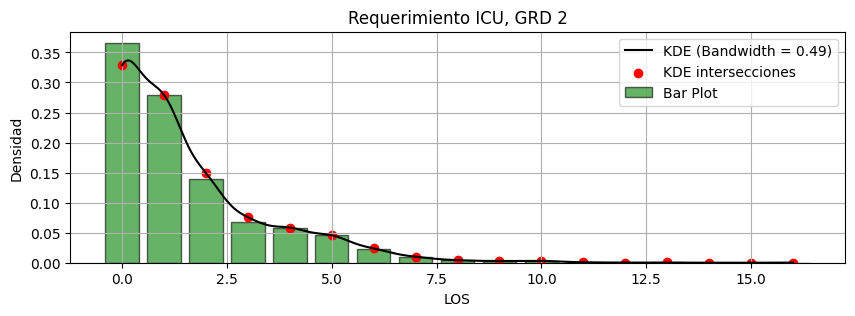

Requerimiento ICU, GRD 2, Chi2: 23.95, p-value: 0.091, Bandwidth: 0.48500000000002086


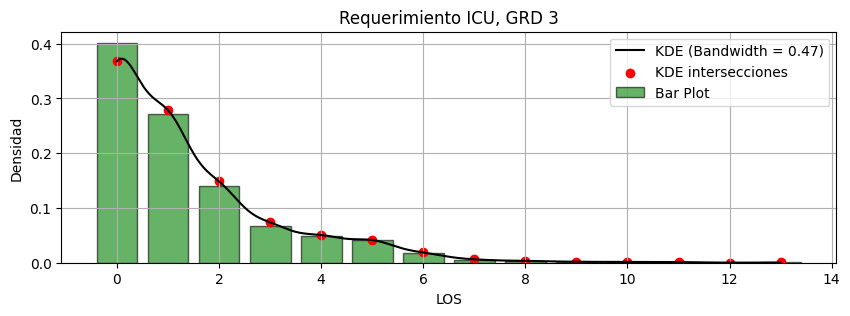

Requerimiento ICU, GRD 3, Chi2: 20.924, p-value: 0.074, Bandwidth: 0.46500000000002084


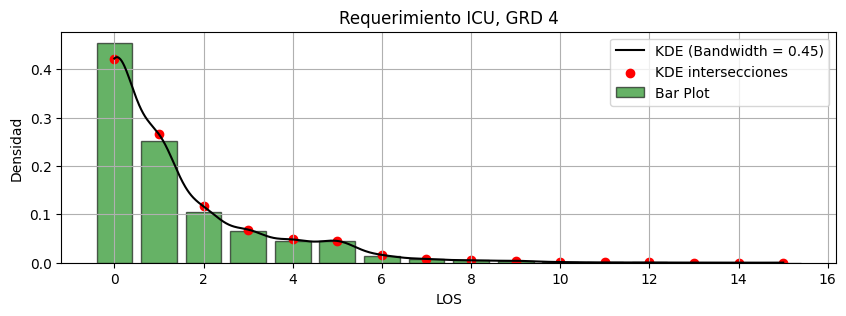

Requerimiento ICU, GRD 4, Chi2: 22.671, p-value: 0.091, Bandwidth: 0.45000000000002083


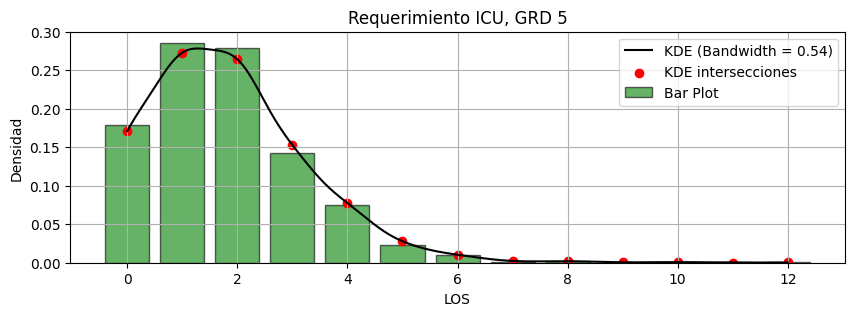

Requerimiento ICU, GRD 5, Chi2: 19.876, p-value: 0.069, Bandwidth: 0.5350000000000209


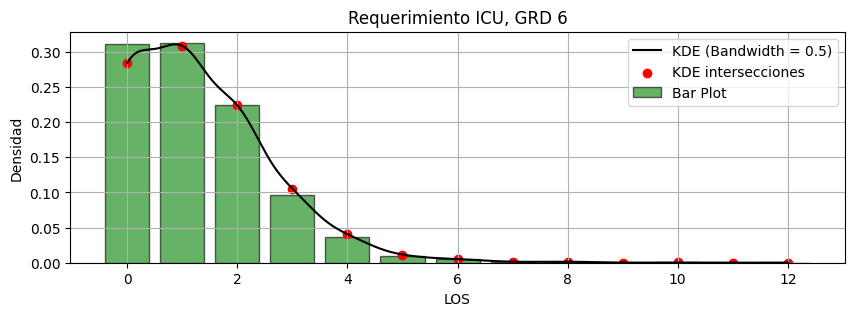

Requerimiento ICU, GRD 6, Chi2: 19.614, p-value: 0.075, Bandwidth: 0.49500000000002087


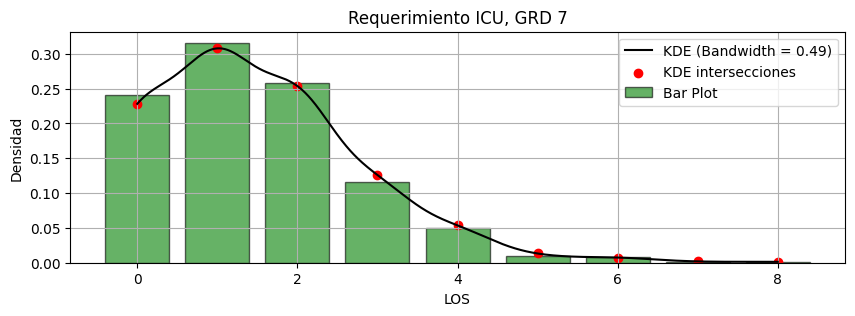

Requerimiento ICU, GRD 7, Chi2: 14.836, p-value: 0.062, Bandwidth: 0.49000000000002086


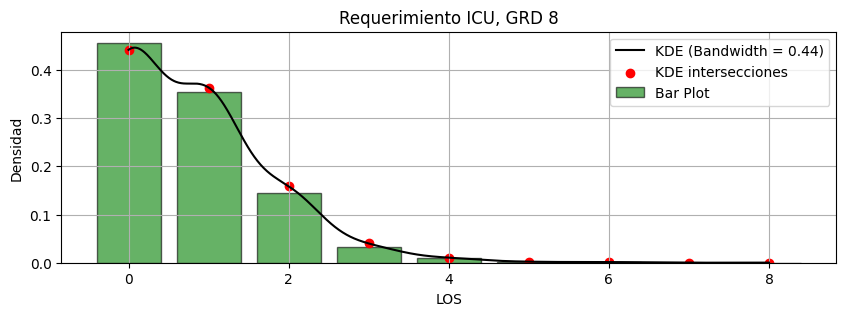

Requerimiento ICU, GRD 8, Chi2: 14.427, p-value: 0.071, Bandwidth: 0.4350000000000208


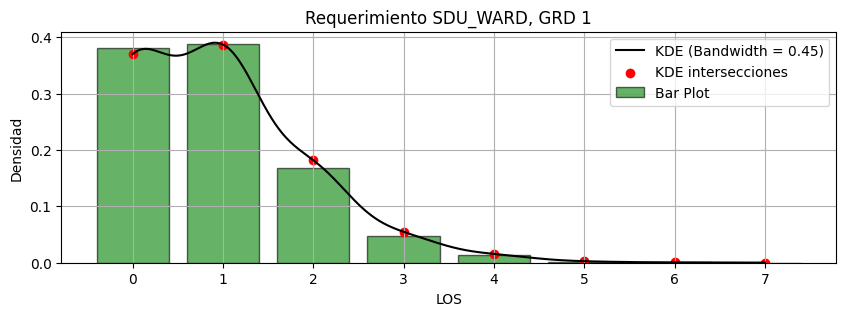

Requerimiento SDU_WARD, GRD 1, Chi2: 12.915, p-value: 0.074, Bandwidth: 0.4450000000000208


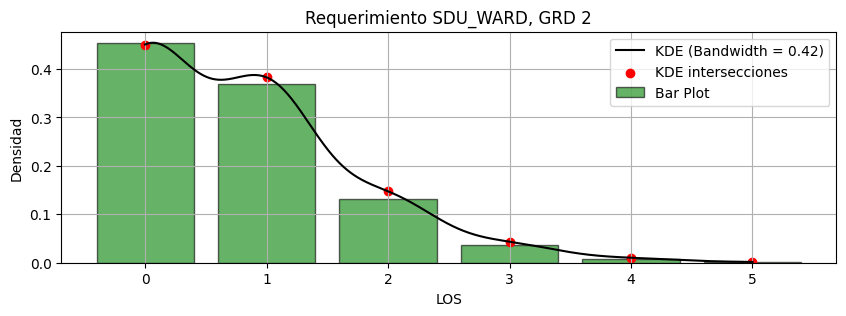

Requerimiento SDU_WARD, GRD 2, Chi2: 9.736, p-value: 0.083, Bandwidth: 0.4200000000000208


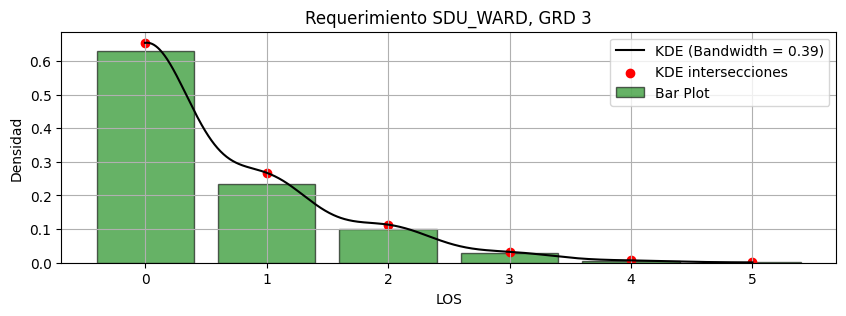

Requerimiento SDU_WARD, GRD 3, Chi2: 9.147, p-value: 0.103, Bandwidth: 0.3900000000000208


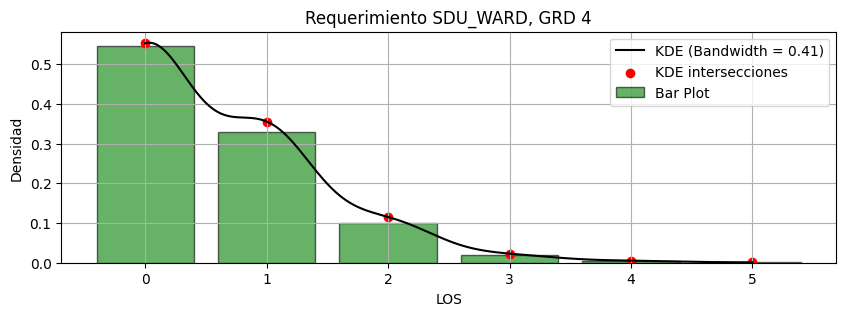

Requerimiento SDU_WARD, GRD 4, Chi2: 9.869, p-value: 0.079, Bandwidth: 0.4050000000000208


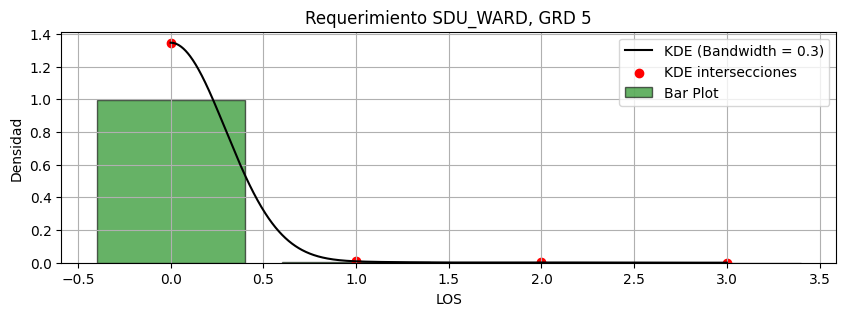

Requerimiento SDU_WARD, GRD 5, Chi2: 6.788, p-value: 0.079, Bandwidth: 0.2950000000000207


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),


ValueError: x and y must have length at least 2.

In [213]:
todo = {}
resultados = []

for requerimiento in ["OR", "ICU", "SDU_WARD"]:
        todo[p.dict_unidades[requerimiento.replace("_","/")]] = {}
        for grd in range(1, 9):
            # Para visualizar los datos de llegadas (cambiar requerimiento y grd que se quiera ver)
            v1 = llegadas[(llegadas["REQUERIMIENTO"] == requerimiento) & (llegadas["MS_GRD"] == grd)]
            vector = v1["TI"].value_counts().reset_index().sort_values(by="TI")
            vector.columns = ["TI", "OCURRENCIAS"]
            v2 = vector["OCURRENCIAS"].value_counts().reset_index()
            v2.columns = ["VALOR", "OCURRENCIAS"]
            v2.sort_values(by="VALOR", inplace=True)

            # Agregar la cantidad de veces que no llego nadie, osea valor 0
            ciclos_simulacion = int(tl["TI"].max()/12)
            # agregar nueva fila
            cero_ocurrencias = {"VALOR": 0, "OCURRENCIAS": ciclos_simulacion - v2["OCURRENCIAS"].sum()}
            v2 = pd.concat([v2, pd.DataFrame([cero_ocurrencias])], ignore_index=True)
            # Ordenar por VALOR
            v2.sort_values(by="VALOR", inplace=True)
            v2.reset_index(inplace=True)
            v2.drop(columns=["index"], inplace=True)

            if len(v2) > 0:
                # Ajuste a kde y calculo de metricas
                kde, kde_pdf, metricas, bandwidth = ajuste_kde(v2["VALOR"], v2["OCURRENCIAS"], bandwidth=2, pvalue=0.06, plot=True, titulo_plot=f'Requerimiento {requerimiento}, GRD {grd}')
            
                # Almacenaje de resultados
                chi2 = metricas["Chi2"]["Value"]
                pvalue = metricas["Chi2"]["p-value"]
                resultados.append({
                    "Requerimiento": requerimiento,
                    "GRD": grd,
                    "Chi2": chi2,
                    "p-value": pvalue,
                    "Bandwidth": bandwidth
                })
                
                todo[p.dict_unidades[requerimiento.replace("_","/")]][grd] = {
                    "kde": kde,
                    "kde_pdf": kde_pdf.tolist(),  # Convert numpy array to list for JSON compatibility
                    "metricas": metricas,
                    "bandwidth": bandwidth
                }
                print(f"Requerimiento {requerimiento}, GRD {grd}, Chi2: {chi2}, p-value: {pvalue}, Bandwidth: {bandwidth}")

In [ ]:
# Ejemplo chat gpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, chisquare, ks_2samp, poisson, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Simulamos datos tipo Poisson
np.random.seed(0)
data = np.random.poisson(lam=4, size=1000)  # λ=4

# 2. Ajustamos KDE
kde = gaussian_kde(data, bw_method='scott')  # puedes ajustar el bw_method
x_range = np.linspace(data.min(), data.max(), 1000)
kde_pdf = kde(x_range)

# 3. Preparamos los datos discretizados para comparación
unique, counts = np.unique(data, return_counts=True)
frequencies = dict(zip(unique, counts))

# 4. Creamos un vector con todos los valores posibles
full_range = np.arange(data.min(), data.max() + 1)
observed = np.array([frequencies.get(x, 0) for x in full_range])
expected_kde = kde(full_range) * observed.sum()
expected_kde *= observed.sum() / expected_kde.sum()  # Escalamos para que sumen lo mismo

# 5. Calculamos métricas de ajuste
def calculate_metrics(y_true, y_pred):
    chi2 = chisquare(f_obs=y_true, f_exp=y_pred)
    ks = ks_2samp(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    cc, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Chi2': {"Value": round(chi2.statistic, 3), "p-value": round(chi2.pvalue, 3)},
        'KS': {"Value": round(ks.statistic, 3), "p-value": round(ks.pvalue, 3)},
        'MAE': {"Value": round(mae, 3), "p-value": "NA"},
        'RMSE': {"Value": round(rmse, 3), "p-value": "NA"},
        'CC': {"Value": round(cc, 3), "p-value": "NA"},
        'R2': {"Value": round(r2, 3), "p-value": "NA"}
    }

metrics = calculate_metrics(observed, expected_kde)

# 6. Visualización
plt.figure(figsize=(10, 5))
plt.bar(full_range, observed, alpha=0.6, label="Observed (counts)")
plt.plot(full_range, expected_kde, color='red', lw=2, label="KDE (expected)")
plt.title("KDE Fit to Poisson-like Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# 7. Mostramos métricas en tabla
metrics_df = pd.DataFrame(metrics).T
display(metrics_df)
